In [1]:
# import basic libraries
import os
import json
import numpy as np
import pandas as pd
import re
import random
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter
import plotly.io as pio
import pyperclip
from sklearn.cluster import KMeans

In [11]:
from transformers import AutoModel, AutoTokenizer
from transformers import PreTrainedTokenizer


In [2]:
from cltk.tokenizers.lat.lat import LatinWordTokenizer as WordTokenizer
from cltk.tokenizers.lat.lat import LatinPunktSentenceTokenizer as SentenceTokenizer
from tensor2tensor.data_generators import text_encoder

In [ ]:
# (1) install gdown python library for downloading large files from google drive
# (2) in terminal, go to a directory where you want to download the BERT model
# (3) run "gdal "https://drive.google.com/uc?id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti""
# (4) mkdir -p ./bert-base-latin-uncased                                      
# (4) unarchive the model: tar -xf latin_bert.tar --strip-components 1 -C ./bert-base-latin-uncased

In [226]:
# we need to implement a very specific Latin tokenizer... (based on https://github.com/dbamman/latin-bert/blob/master/scripts/gen_berts.py)


class LatinTokenizer:
    def __init__(self, vocab_file, encoder, **kwargs):
        self.encoder = encoder
        self.vocab = {}
        self.reverse_vocab = {}
        self._load_vocab(vocab_file)

    def _load_vocab(self, vocab_file):
        with open(vocab_file, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                token = line.strip()
                self.vocab[token] = idx
                self.reverse_vocab[idx] = token

    def convert_tokens_to_ids(self, tokens):
        return [self.vocab.get(token, self.vocab.get('[UNK]', 1)) for token in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self.reverse_vocab.get(i, '[UNK]') for i in ids]

    def tokenize(self, text):
        tokens = text.split()
        wp_tokens = []
        for token in tokens:
            if token in self.vocab:
                wp_tokens.append(token)
            else:
                wp_toks = self.encoder.encode(token)
                wp_tokens.extend([self.reverse_vocab.get(wp + 5, '[UNK]') for wp in wp_toks])
        return wp_tokens

    def encode(self, text):
        tokens = self.tokenize(text)
        return self.convert_tokens_to_ids(tokens)

    def __call__(self, text, return_tensors=None, padding=False, truncation=False, max_length=None, return_offsets_mapping=False):
        tokens = self.tokenize(text)
        input_ids = self.convert_tokens_to_ids(tokens)

        # Create output dictionary
        output = {
            'input_ids': input_ids,
            'tokens': tokens
        }

        if return_tensors == 'pt':
            import torch
            # Convert to tensor and handle padding/truncation
            input_ids_tensor = torch.tensor([input_ids])
            if padding:
                # Handle padding
                pad_length = max_length - len(input_ids) if max_length else 0
                if pad_length > 0:
                    input_ids_tensor = torch.cat([input_ids_tensor, torch.zeros((1, pad_length), dtype=torch.long)], dim=1)
            if truncation and max_length and len(input_ids) > max_length:
                input_ids_tensor = input_ids_tensor[:, :max_length]

            output['input_ids'] = input_ids_tensor

        if return_offsets_mapping:
            # Simulate offsets mapping (just placeholder logic)
            offsets = [(0, len(text)) for _ in tokens]
            output['offset_mapping'] = offsets

        return output

In [227]:
# Initialize the tokenizer with the vocab.txt file and the encoder
vocab_file_path = "/Users/vojtechkase/Projects/latin-bert/models/latin_bert/vocab.txt"  # Update this path
tokenizer_path = "/Users/vojtechkase/Projects/latin-bert/models/subword_tokenizer_latin/latin.subword.encoder"
# Update this path
encoder = text_encoder.SubwordTextEncoder(tokenizer_path)
tokenizer = LatinTokenizer(vocab_file_path, encoder)

In [228]:
model = AutoModel.from_pretrained("../bert-base-latin-uncased/")

In [229]:
sent = "verum ex libro naturae nos hausimus aliqualem illam conformitatem in facultatibus à seminum & aliarum partium similitudine."
input_ids = tokenizer.encode(sent)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

['verum_', 'ex', 'libro_', 'naturae_', 'nos', 'hausi', 'mus_', 'aliqua', 'lem_', 'illam_', 'conformi', 'tatem_', 'in', 'facultatibus_', 'à', 'semi', 'num_', '&', 'aliarum_', 'partium_', 'similit', 'udin', 'e_', '._']


In [230]:
inputs = tokenizer(sent, return_tensors='pt', padding=True, truncation=True, max_length=512, return_offsets_mapping=True)
input_ids = inputs['input_ids']
input_ids[0][:20] #bert_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

tensor([  358,  3641,   651,   601,  4879, 22997,   104, 14893,   649,   557,
        19933,   654,  7556, 26072,  5882,  1950,   310, 31547,  5667,  3464])

# Loading and processing Noscemus textual data

In [46]:
metadata_table_long = pd.read_json("../../noscemus_ETF/data/metadata_table_long.json")
metadata_table_long.head(5)

Author                                         Full title  \
0  Achrelius, Daniel  Scientiarum magnes recitatus publice anno 1690...   
1  Acidalius, Valens                 Ad Iordanum Brunum Nolanum, Italum   
2    Acosta, José de  De natura novi orbis libri duo et De promulgat...   
3     Adam, Melchior  Vitae Germanorum medicorum, qui saeculo superi...   
4    Addison, Joseph  Ad insignissimum virum dominum Thomam Burnettu...   

                                                  In  Year              Place  \
0                                               None  1690            [Turku]   
1  Poematum Iani Lernutii, Iani Gulielmi, Valenti...  1603  Liegnitz, Wrocław   
2                                               None  1589          Salamanca   
3                                               None  1620         Heidelberg   
4  Examen poeticum duplex, sive, Musarum anglican...  1698             London   

       Publisher/Printer           Era      Form/Genre  \
0                   Wall  17th century         Oration   
1          Albert, David  17th century  Panegyric poem   
2       Guillelum Foquel  16th century       Monograph   
3           Rosa, Geyder  17th century       Biography   
4  Richard Wellington I.  17th century  Panegyric poem   

                                  Discipline/Content  \
0  Mathematics, Astronomy/Astrology/Cosmography, ...   
1                    Astronomy/Astrology/Cosmography   
2  Astronomy/Astrology/Cosmography, Geography/Car...   
3                                           Medicine   
4                         Meteorology/Earth sciences   

                                            Original  ...       ids      id  \
0                   Scientiarum magnes(Google Books)  ...  [705665]  705665   
1  Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...  ...  [801745]  801745   
2  De natura novi orbis(Biodiversity Heritage Lib...  ...  [713323]  713323   
3  Vitae Germanorum medicorum(MDZ)Alternative lin...  ...  [693148]  693148   
4  Ad Burnettum sacrae theoriae telluris auctorem...  ...  [769230]  769230   

  date_min date_max                                           filename  \
0   1690.0   1690.0  Achrelius,_Daniel_-_Scientiarum_magnes__Turku_...   
1   1603.0   1603.0  Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...   
2   1589.0   1589.0  Acosta,_José_de_-_De_natura_novi_orbis__Salama...   
3   1620.0   1620.0  Adam,_Melchior_-_Vitae_Germanorum_medicorum__H...   
4   1698.0   1698.0        Examen_poeticum_duplex__London_1698_pdf.txt   

  file_year sents_n words_n  \
0    1690.0     518    6685   
1    1603.0    6137   66744   
2    1589.0    9040  135979   
3    1620.0   16258  153868   
4    1698.0    3297   38011   

                                    disciplines_list   science_class  
0  [Mathematics, Astronomy/Astrology/Cosmography,...         mixture  
1                  [Astronomy/Astrology/Cosmography]  exact_sciences  
2  [Astronomy/Astrology/Cosmography, Geography/Ca...  exact_sciences  
3                                         [Medicine]   life_sciences  
4                       [Meteorology/Earth sciences]  exact_sciences  

[5 rows x 30 columns]

In [47]:
id_year_dict = dict(zip(metadata_table_long["id"].astype(str), metadata_table_long["file_year"]))

In [48]:
id_author_dict = dict(zip(metadata_table_long["id"].astype(str), metadata_table_long["Author"].apply(lambda x: x.partition(",")[0])))

In [49]:
def get_sentence_data(target_lemma, path="../../noscemus_ETF/data/large_data/sents_data/"):
    target_sentences = []  
    fns = os.listdir(path)
    for fn in fns:
        sents_data = pickle.load(open(path + fn, "rb"))
        for sent_n, (sent_text, sent_data) in enumerate(sents_data):
            lemmata = [tup[1] for tup in sent_data]
            if target_lemma in lemmata:
                sent_data = sents_data[sent_n]
                target_sentences.append((fn, sent_n, sent_data[0], sent_data[1]))
    return target_sentences

In [50]:
tar_sents = get_sentence_data("liber")

In [51]:
len(tar_sents)

117052

In [52]:
tar_sents_nouns = []
for sent_data in tar_sents:
    if [tup for tup in sent_data[3] if (tup[1]=="liber") & (tup[2]=="NOUN")]:
        tar_sents_nouns.append(sent_data)    

In [53]:
len(tar_sents_nouns)

104021

In [54]:
sents_meta = [sent_data for sent_data in tar_sents if re.search(r"lib\w{2,3} natura",  sent_data[2])]
sents_meta[:10]

[('798544.pickle',
  13584,
  'Varia continet ille liber naturalia, moralia, historica;',
  [('Varia', 'uarua', 'PRON', (0, 5)),
   ('continet', 'contineo', 'VERB', (6, 14)),
   ('ille', 'ille', 'DET', (15, 19)),
   ('liber', 'liber', 'NOUN', (20, 25)),
   ('naturalia', 'naturalis', 'ADJ', (26, 35)),
   (',', ',', 'PUNCT', (35, 36)),
   ('moralia', 'moralis', 'ADJ', (37, 44)),
   (',', ',', 'PUNCT', (44, 45)),
   ('historica', 'historicus', 'ADJ', (46, 55)),
   (';', ';', 'PUNCT', (55, 56))]),
 ('701513.pickle',
  1813,
  'Et dicunt hominem esse minorem mundum etiam ob hoc: quia in ma nu tanquam in libro naturae locantur & septem planetae, & etiam xii.',
  [('Et', 'et', 'CCONJ', (0, 2)),
   ('dicunt', 'dico', 'VERB', (3, 9)),
   ('hominem', 'homo', 'NOUN', (10, 17)),
   ('esse', 'sum', 'AUX', (18, 22)),
   ('minorem', 'paruus', 'ADJ', (23, 30)),
   ('mundum', 'mundus', 'NOUN', (31, 37)),
   ('etiam', 'etiam', 'ADV', (38, 43)),
   ('ob', 'ob', 'ADP', (44, 46)),
   ('hoc', 'hic', 'DET', 

In [55]:
len(sents_meta)

151

In [56]:
tar_sents[:10]

[('693174.pickle',
  53,
  'fecit, vt ab affine Diniensi, qui liberos paulò inferioris nota nec eò quo Gassendvlvs prouectos habebat; Aquas Sextias missus fuerit, quò Philosophicis studiis sub Fesaio Minorita doctissimo, incumbere posset.',
  [('fecit', 'facio', 'VERB', (0, 5)),
   (',', ',', 'PUNCT', (5, 6)),
   ('vt', 'vt', 'SCONJ', (7, 9)),
   ('ab', 'ab', 'ADP', (10, 12)),
   ('affine', 'affinis', 'NOUN', (13, 19)),
   ('Diniensi', 'diniensis', 'PROPN', (20, 28)),
   (',', ',', 'PUNCT', (28, 29)),
   ('qui', 'qui', 'PRON', (30, 33)),
   ('liberos', 'liber', 'ADJ', (34, 41)),
   ('paulò', 'paulò', 'ADV', (42, 47)),
   ('inferioris', 'inferus', 'ADJ', (48, 58)),
   ('nota', 'notus', 'ADJ', (59, 63)),
   ('nec', 'nec', 'CCONJ', (64, 67)),
   ('eò', 'eò', 'ADP', (68, 70)),
   ('quo', 'qui', 'PRON', (71, 74)),
   ('Gassendvlvs', 'gassendvlv', 'PROPN', (75, 86)),
   ('prouectos', 'proucio', 'VERB', (87, 96)),
   ('habebat', 'habeo', 'VERB', (97, 104)),
   (';', ';', 'PUNCT', (104, 105)),

# Generating embeddings

In [266]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def get_decontextualized_embeddings(word: str):
    input_ids = tokenizer.encode(word) # , add_special_tokens=False)
    word_emb = model.get_input_embeddings()
    embeddings = word_emb(torch.LongTensor(input_ids))
    return embeddings.mean(0).detach().numpy()

def compute_offsets(text, tokens):
    """
    Compute character offsets for each token in the original text.
    """
    offsets = []
    token_start = 0

    for token in tokens:
        # Find the start position of the token in the original text
        start_idx = text.find(token, token_start)
        if start_idx == -1:
            # Token not found in the remaining text
            continue
        end_idx = start_idx + len(token)
        offsets.append((start_idx, end_idx))
        token_start = end_idx  # Move start index for the next search

    return offsets

def compute_offsets(text, tokens):
    """
    Compute character offsets for each token in the original text.
    """
    offsets = []
    current_pos = 0
    for token in tokens:
        # Handle leading spaces and special characters
        token = token.replace("Ġ", "")
        start_idx = text.find(token, current_pos)
        if start_idx == -1:
            # Token not found, possibly a split token or special case
            # Attempt to find token by removing special characters
            cleaned_token = token.replace('_', '')
            start_idx = text.find(cleaned_token, current_pos)
            if start_idx != -1:
                end_idx = start_idx + len(cleaned_token)
                offsets.append((start_idx, end_idx))
                current_pos = end_idx
            else:
                # If still not found, append a dummy offset
                offsets.append((current_pos, current_pos + len(token)))
        else:
            end_idx = start_idx + len(token)
            offsets.append((start_idx, end_idx))
            current_pos = end_idx

    return offsets


def get_embeddings_data(sent, tokenized_data):
    # Tokenize and prepare input tensors
    inputs = tokenizer(sent.lower(), return_tensors='pt', padding=True, truncation=True, max_length=512) #return_offsets_mapping=True)

    input_ids_tensor = inputs['input_ids']
    attention_mask_tensor = inputs.get('attention_mask', torch.ones_like(input_ids_tensor))

    # Convert input IDs to tokens
    bert_tokens = tokenizer.convert_ids_to_tokens(input_ids_tensor[0].tolist())
    offset_mapping = compute_offsets(sent, bert_tokens)

    # Model forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        last_hidden_state = outputs.last_hidden_state
        bert_sentence_embeddings = last_hidden_state.mean(dim=1).squeeze().detach().numpy()
        bert_token_embeddings = last_hidden_state[0].detach().numpy()

    # Prepare tokens data for comparison
    tokens_data_updated = [(token, offset, embedding) for token, offset, embedding in zip(bert_tokens, offset_mapping, bert_token_embeddings)]

    covered_tups = []
    for word_tuple in tokenized_data:
        start_offset, end_offset = word_tuple[-1]
    
        # Extract covered tokens and embeddings
        covered_tokens = [tup[0] for tup in tokens_data_updated if start_offset <= tup[1][0] < end_offset]
        covered_embeddings = [tup[2] for tup in tokens_data_updated if start_offset <= tup[1][0] < end_offset]
    
        # Compute average embedding
        if covered_embeddings:
            embedding_avg = np.mean(covered_embeddings, axis=0)
        else:
            embedding_avg = np.zeros(768)
    
        # Decontextualized embedding
        embedding_decontext = get_decontextualized_embeddings(word_tuple[0])
    
        # Compute similarity score
        embedding_avg_2d = embedding_avg.reshape(1, -1)
        embedding_decontext_2d = embedding_decontext.reshape(1, -1)
        if np.isnan(embedding_avg).any() or np.isnan(embedding_decontext).any():
            similarity_score = None
        else:
            similarity_score = cosine_similarity(embedding_avg_2d, embedding_decontext_2d)[0, 0]
    
        # Append to results
        covered_tups.append((
            word_tuple[0],    # spacy_tokens
            word_tuple[1],    # spacy_lemma
            word_tuple[2],    # spacy_pos
            word_tuple[3],    # spacy_position
            covered_tokens,   # bert_tokens
            covered_embeddings, # bert_tok_emb
            embedding_avg.tolist(),   # Convert numpy array to list
            embedding_decontext.tolist(), # Convert numpy array to list
            similarity_score # cos_sim
        ))
    
    # Create DataFrame
    df = pd.DataFrame(covered_tups, columns=[
        "spacy_tokens", "spacy_lemma", "spacy_pos", "spacy_position",
        "bert_tokens", "bert_tok_emb", "bert_avg_emb", "bert_avg_decontext", "cos_sim"
    ])

    return bert_sentence_embeddings, df


In [267]:
sent = sents_meta[8][2]
sent

'verum ex libro naturae nos hausimus aliqualem illam conformitatem in facultatibus à seminum & aliarum partium similitudine.'

In [268]:
 # Tokenize and prepare input tensors
inputs = tokenizer(sent.lower(), return_tensors='pt', padding=True, truncation=True, max_length=512)

In [269]:
input_ids = tokenizer.encode(sent)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
tokens

['verum_',
 'ex',
 'libro_',
 'naturae_',
 'nos',
 'hausi',
 'mus_',
 'aliqua',
 'lem_',
 'illam_',
 'conformi',
 'tatem_',
 'in',
 'facultatibus_',
 'à',
 'semi',
 'num_',
 '&',
 'aliarum_',
 'partium_',
 'similit',
 'udin',
 'e_',
 '._']

In [270]:
inputs

{'input_ids': tensor([[  358,  3641,   651,   601,  4879, 22997,   104, 14893,   649,   557,
          19933,   654,  7556, 26072,  5882,  1950,   310, 31547,  5667,  3464,
          22806, 12167,    23,     8,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,    

In [273]:
tokenized_data = sents_meta[8][3]
tokenized_data

[('verum', 'uerus', 'ADJ', (0, 5)),
 ('ex', 'ex', 'ADP', (6, 8)),
 ('libro', 'liber', 'NOUN', (9, 14)),
 ('naturae', 'natura', 'NOUN', (15, 22)),
 ('nos', 'nos', 'PRON', (23, 26)),
 ('hausimus', 'hausio', 'VERB', (27, 35)),
 ('aliqualem', 'aliqualis', 'ADJ', (36, 45)),
 ('illam', 'ille', 'DET', (46, 51)),
 ('conformitatem', 'conformitas', 'NOUN', (52, 65)),
 ('in', 'in', 'ADP', (66, 68)),
 ('facultatibus', 'facultas', 'NOUN', (69, 81)),
 ('à', 'à', 'ADP', (82, 83)),
 ('seminum', 'semen', 'NOUN', (84, 91)),
 ('&', '&', 'PUNCT', (92, 93)),
 ('aliarum', 'alius', 'DET', (94, 101)),
 ('partium', 'pars', 'NOUN', (102, 109)),
 ('similitudine', 'similitudo', 'NOUN', (110, 122)),
 ('.', '.', 'PUNCT', (122, 123))]

In [274]:
# sent = "Nulla res humana maior est quam scientia, quae hominem ad altiora perducit et ad sapientiam veram dirigit."
sentence_emb, df = get_embeddings_data(sent.lower(), tokenized_data)
df

spacy_tokens  spacy_lemma spacy_pos spacy_position          bert_tokens  \
0           verum        uerus       ADJ         (0, 5)             [verum_]   
1              ex           ex       ADP         (6, 8)                 [ex]   
2           libro        liber      NOUN        (9, 14)             [libro_]   
3         naturae       natura      NOUN       (15, 22)           [naturae_]   
4             nos          nos      PRON       (23, 26)                [nos]   
5        hausimus       hausio      VERB       (27, 35)        [hausi, mus_]   
6       aliqualem    aliqualis       ADJ       (36, 45)       [aliqua, lem_]   
7           illam         ille       DET       (46, 51)             [illam_]   
8   conformitatem  conformitas      NOUN       (52, 65)   [conformi, tatem_]   
9              in           in       ADP       (66, 68)                 [in]   
10   facultatibus     facultas      NOUN       (69, 81)      [facultatibus_]   
11              à            à       ADP       (82, 83)                  [à]   
12        seminum        semen      NOUN       (84, 91)         [semi, num_]   
13              &            &     PUNCT       (92, 93)                  [&]   
14        aliarum        alius       DET      (94, 101)           [aliarum_]   
15        partium         pars      NOUN     (102, 109)           [partium_]   
16   similitudine   similitudo      NOUN     (110, 122)  [similit, udin, e_]   
17              .            .     PUNCT     (122, 123)                 [._]   

                                         bert_tok_emb  \
0   [[-0.33248046, 0.025983885, -0.5973006, -0.958...   
1   [[-0.08210932, 0.016235514, -0.4178436, -0.985...   
2   [[-0.16391999, -0.12280244, -0.7436661, -0.570...   
3   [[-0.39240885, -0.012050062, -0.5854431, -0.77...   
4   [[-0.33822846, 0.08142765, -0.25834498, -1.179...   
5   [[-0.7224071, 0.32423198, -0.31658444, -1.3718...   
6   [[-0.34591112, 0.03088506, 0.20702413, -1.0116...   
7   [[-0.35496792, -0.022838896, -0.06549203, -0.8...   
8   [[-0.16854915, 0.4396764, -0.7073521, -0.34889...   
9   [[-0.17363797, -0.049449857, -0.11445054, -0.8...   
10  [[-0.3711565, -0.012344746, -0.319659, -0.9340...   
11  [[-0.41332468, -0.1309255, -0.5543748, -0.7191...   
12  [[-0.62991905, -0.089301765, -0.2926845, -0.67...   
13  [[-0.41088596, -0.03356018, -0.65065426, -0.74...   
14  [[-0.4217888, -0.1339179, -0.6957664, -0.86113...   
15  [[-0.25530568, 0.003906466, -0.20355797, -1.05...   
16  [[-0.43835357, -0.007061642, -0.7393037, -0.81...   
17  [[-0.4761457, -0.18177855, -1.1179596, -0.9616...   

                                         bert_avg_emb  \
0   [-0.33248046040534973, 0.025983884930610657, -...   
1   [-0.08210931718349457, 0.016235513612627983, -...   
2   [-0.16391998529434204, -0.12280243635177612, -...   
3   [-0.3924088478088379, -0.012050062417984009, -...   
4   [-0.3382284641265869, 0.08142764866352081, -0....   
5   [-0.541472315788269, 0.0916764885187149, -0.55...   
6   [-0.34773164987564087, -0.2098926603794098, -0...   
7   [-0.3549679219722748, -0.0228388961404562, -0....   
8   [-0.25258004665374756, 0.20476314425468445, -0...   
9   [-0.1736379712820053, -0.0494498573243618, -0....   
10  [-0.3711565136909485, -0.01234474591910839, -0...   
11  [-0.4133246839046478, -0.1309255063533783, -0....   
12  [-0.4305958151817322, -0.24708597362041473, -0...   
13  [-0.4108859598636627, -0.03356017917394638, -0...   
14  [-0.4217888116836548, -0.133917897939682, -0.6...   
15  [-0.255305677652359, 0.003906466066837311, -0....   
16  [-0.3313951790332794, -0.1864001750946045, -0....   
17  [-0.4761457145214081, -0.18177855014801025, -1...   

                                   bert_avg_decontext   cos_sim  
0   [0.004395849071443081, 0.05527312308549881, -0... -0.012018  
1   [0.10569006949663162, 0.04669884219765663, 0.0...  0.077383  
2   [-0.024198127910494804, -0.011869133450090885,...  0.118047  
3   [0.024791700765490532, -0.019312333315610886, ..

In [136]:
n = 5000
tar_sents_sample = random.sample(tar_sents, n)

In [26]:
%%time
sents_dfs = []
for sent_data in sents_meta + tar_sents_sample:
    sent_emb, df = get_embeddings_data(sent_data[2], sent_data[3])
    sents_dfs.append((sent_data[0], sent_data[1], sent_data[2], sent_emb, df))

CPU times: user 7min 29s, sys: 54 s, total: 8min 23s
Wall time: 2min 12s


In [27]:
type(list(id_year_dict.keys())[0])

str

In [28]:
len(id_year_dict)

975

In [29]:
ids = [s[0].partition(".")[0] for s in sents_dfs]
years = [id_year_dict[id] if id in id_year_dict.keys() else None for id in ids]
years[:10]

[1708.0,
 1521.0,
 1612.0,
 1704.0,
 1672.0,
 1672.0,
 1672.0,
 1672.0,
 1672.0,
 1672.0]

In [30]:
authors = [id_author_dict[id] if id in id_author_dict.keys() else None for id in ids]
authors[:10]

['Morhof',
 'Mundinus',
 'Pereira',
 'Baglivi',
 'Morison',
 'Morison',
 'Morison',
 'Morison',
 'Morison',
 'Morison']

In [31]:
df = sents_dfs[0][4]
df

spacy_tokens spacy_lemma spacy_pos spacy_position      bert_tokens  \
0        Varia       uarua      PRON         (0, 5)          [varia]   
1     continet    contineo      VERB        (6, 14)       [continet]   
2         ille        ille       DET       (15, 19)           [ille]   
3        liber       liber      NOUN       (20, 25)          [liber]   
4    naturalia   naturalis       ADJ       (26, 35)      [naturalia]   
5            ,           ,     PUNCT       (35, 36)              [,]   
6      moralia     moralis       ADJ       (37, 44)        [moralia]   
7            ,           ,     PUNCT       (44, 45)              [,]   
8    historica  historicus       ADJ       (46, 55)  [histor, ##ica]   
9            ;           ;     PUNCT       (55, 56)              [;]   

                                        bert_tok_emb  \
0  [[-1.0708613, 0.0807188, 0.29972118, -0.690662...   
1  [[0.31272274, 0.9557393, 1.156229, 0.4084524, ...   
2  [[-1.4123368, 1.3125184, 0.08238612, 0.9965102...   
3  [[-0.252175, 1.5811646, -0.0056074173, 0.70705...   
4  [[0.038117528, 0.9984158, 1.1282481, -0.811457...   
5  [[-1.0670701, 0.8965386, 0.1538071, -0.5142650...   
6  [[-1.3058926, 1.0786531, 1.5417608, -1.187896,...   
7  [[-0.9808849, 0.835343, -0.05082961, -0.532389...   
8  [[0.076592684, -0.5323577, 0.8583552, 0.840686...   
9  [[0.44764578, 0.11370212, 0.6606443, -2.231164...   

                                        bert_avg_emb  \
0  [-1.0708613, 0.0807188, 0.29972118, -0.6906621...   
1  [0.31272274, 0.9557393, 1.156229, 0.4084524, -...   
2  [-1.4123368, 1.3125184, 0.08238612, 0.99651027...   
3  [-0.252175, 1.5811646, -0.0056074173, 0.707054...   
4  [0.038117528, 0.9984158, 1.1282481, -0.8114571...   
5  [-1.0670701, 0.8965386, 0.1538071, -0.51426506...   
6  [-1.3058926, 1.0786531, 1.5417608, -1.187896, ...   
7  [-0.9808849, 0.835343, -0.05082961, -0.5323896...   
8  [0.045721836, 0.18527862, 1.2115936, 0.9627361...   
9  [0.44764578, 0.11370212, 0.6606443, -2.231164,...   

                                  bert_avg_decontext   cos_sim  
0  [0.010712932, -0.00070550316, 0.0037266784, -0... -0.041379  
1  [0.016521702, -0.00035617227, 0.014753791, 0.0...  0.322535  
2  [-0.027173994, 0.05382488, 0.01422203, -0.0112...  0.324054  
3  [-0.008960236, 0.0070085437, -0.0061523207, -0...  0.329384  
4  [-0.017809639, -0.030979285, 0.025086744, 0.01...  0.277355  
5  [0.016048621, 0.056904953, -0.038775675, -0.02...  0.185214  
6  [0.0056951116, -0.022340799, 0.0005431548, 0.0...  0.227959  
7  [0.016048621, 0.056904953, -0.038775675, -0.02...  0.185533  
8  [0.008416215, 0.0084134, 0.007014646, -0.00877...  0.311768  
9  [0.041796807, -0.00019711335, -0.004592972, -0...  0.241463

In [32]:
sentences = [sent_data[2] for sent_data in sents_dfs]
sentences[:3]

['Varia continet ille liber naturalia, moralia, historica;',
 'Et dicunt hominem esse minorem mundum etiam ob hoc: quia in ma nu tanquam in libro naturae locantur & septem planetae, & etiam xii.',
 'Tales erant apud Persas Magi (ait Philo in libro, Quod omnis probus sit liber naturae scrutatores, prae veritatis cognoscendae studio, qui per otium diuinas virtutes contemplantur clarius, & alios iisdem initiant mysteriis.']

In [276]:
def insert_newlines(input_str, word_count=10):
    words = input_str.split(' ')
    for i in range(word_count - 1, len(words), word_count):
        words[i] = words[i] + '<br>'
    return ' '.join(words)

In [277]:
hover_text = [insert_newlines(sent) + " ({0} {1})".format(author, str(year)) for sent, author, year in zip(sentences, authors, years)]
print(hover_text[:10])

['Varia continet ille liber naturalia, moralia, historica; (Morhof 1708.0)', 'Et dicunt hominem esse minorem mundum etiam ob hoc: quia<br> in ma nu tanquam in libro naturae locantur & septem<br> planetae, & etiam xii. (Mundinus 1521.0)', 'Tales erant apud Persas Magi (ait Philo in libro, Quod<br> omnis probus sit liber naturae scrutatores, prae veritatis cognoscendae studio,<br> qui per otium diuinas virtutes contemplantur clarius, & alios iisdem<br> initiant mysteriis. (Pereira 1612.0)', 'De morbo enim aliquo tractaturi libros, & phantasiam propriam consulebant,<br> neglectâ prorsus experientiâ, & libro naturae: (Baglivi 1704.0)', 'Prodeat interim primò sub vestris auspiciis Umbellarum doctrina jam restituta,<br> & ab infinitis erroribus & gravibus hallucinationibus (quibus hucusque scatebat)<br> purgata, & ad novem genera summa redacta, à diversâ formâ<br> & figurâ seminum sic à nobis constituta, & composita, ac<br> ex libro naturae observata, cum intermediis suis distributionibus à 

In [278]:
target = "liber"
target_vectors = [] 
for sent_data in sents_dfs:
    df = sent_data[4]
    target_row = df.loc[df["spacy_lemma"] == target].iloc[0]
    target_vectors.append(target_row['bert_avg_emb'])

In [279]:
target_embeddings = np.vstack(target_vectors)
cosine_sim_matrix = pd.DataFrame(cosine_similarity(target_embeddings), index=sentences, columns=sentences)

In [280]:
cosine_sim_matrix.iloc[0].sort_values(ascending=False)

Varia continet ille liber naturalia, moralia, historica;                                                                                                                                                                                                         1.000000
Varia continet ille liber naturalia, moralia, historica;                                                                                                                                                                                                         1.000000
De typis liber, ab Aug. Gadaldino, antiquorum exemplarium Graecorum & ueteris transla tionis ope, tr.                                                                                                                                                            0.976529
De summo bono, Liber Tetim, seu de humanis consiliis Dialogus.                                                                                                                                            

In [285]:
tsne = TSNE(n_components=1, perplexity=10)
embeddings_tsne = tsne.fit_transform(target_embeddings)

In [290]:
tsne = TSNE(n_components=2, perplexity=40)
embeddings_tsne2d = tsne.fit_transform(target_embeddings)

In [291]:
len(embeddings_tsne2d)

5151

In [292]:
len(years)

5151

In [293]:
colors = ["red"] * len(sents_meta) + ["green"] * len(tar_sents_sample)
len(colors)

5151

(1450.0, 1750.0)

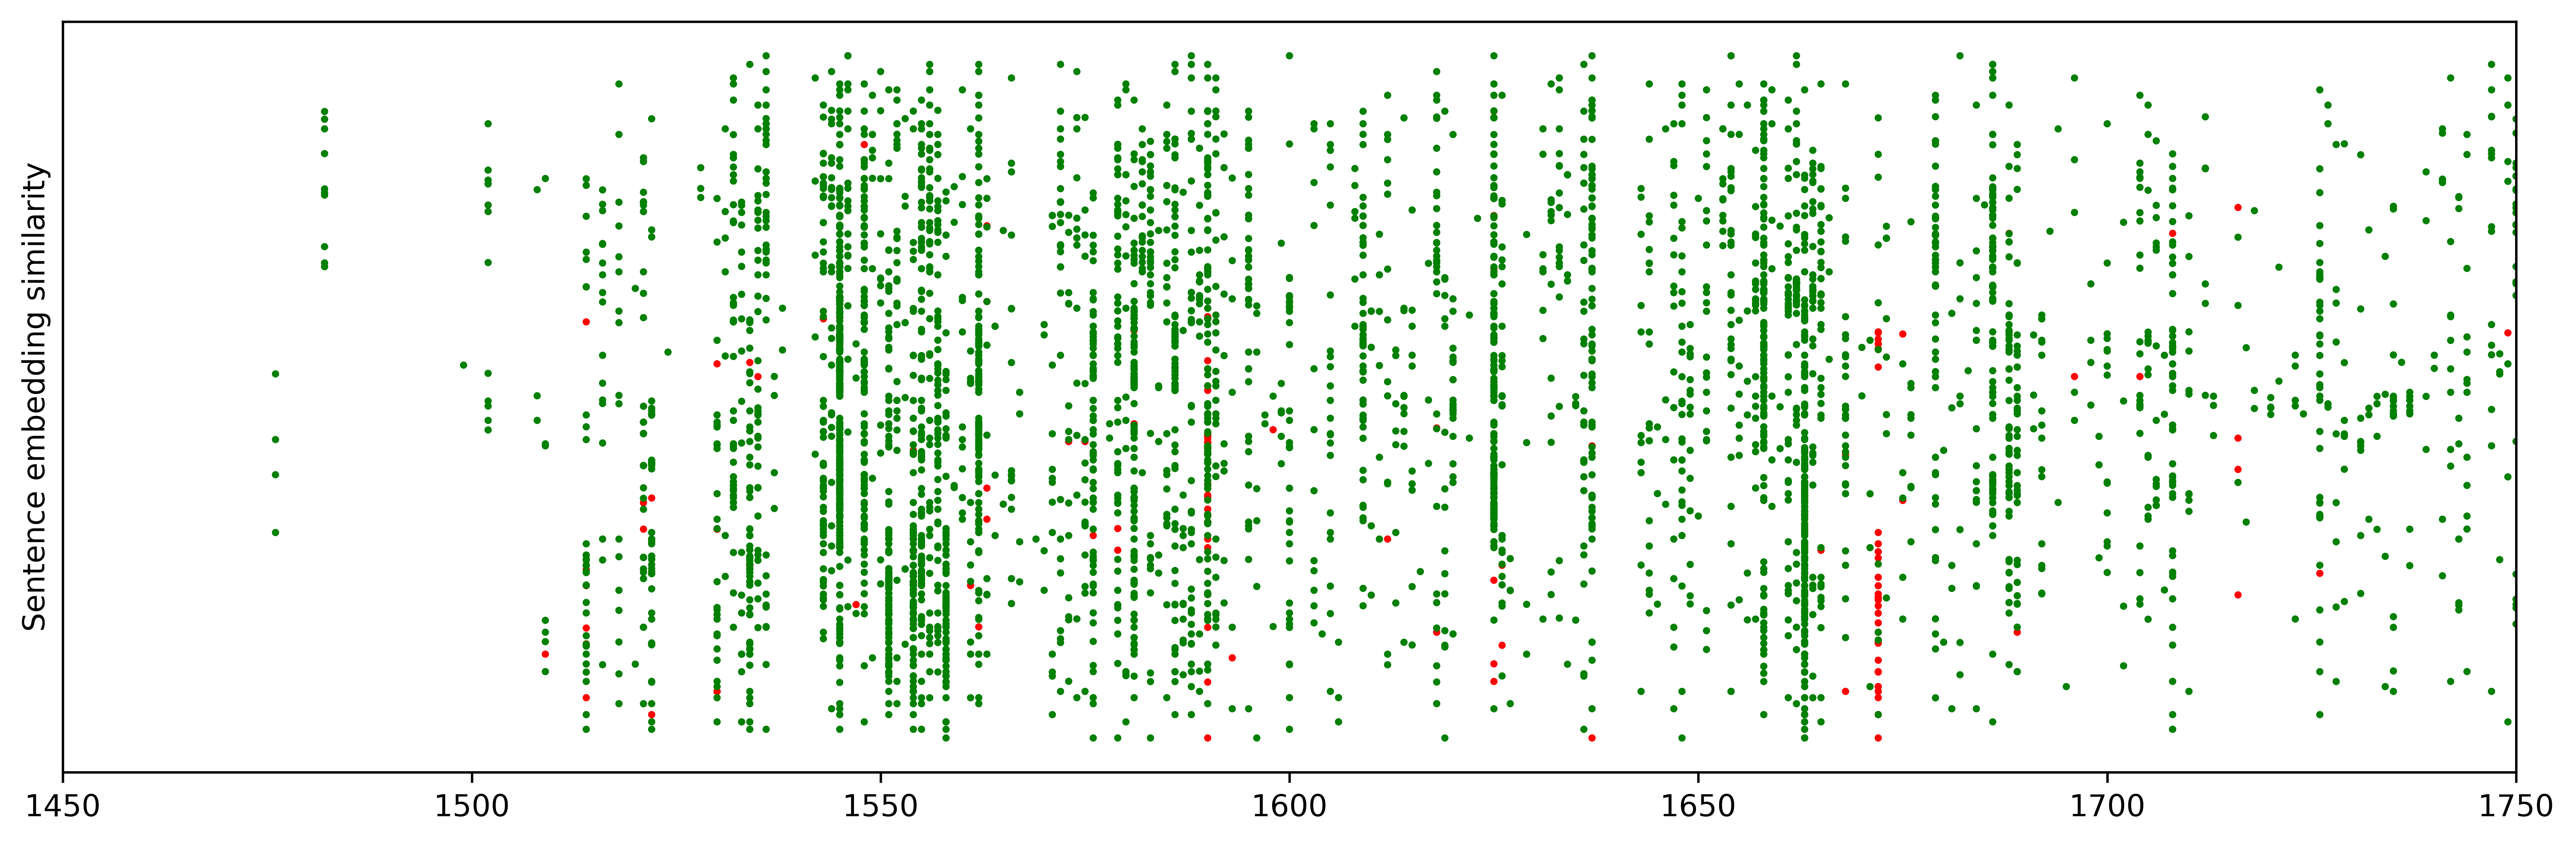

In [294]:
fig, ax = plt.subplots(tight_layout=True, dpi=600, figsize=(12,4))
ax.scatter(x=years, y=embeddings_tsne, c=colors, s=2)# You may want to adjust the size depending on your similarity matrix
ax.set_yticks([])
ax.set_ylabel("Sentence embedding similarity")
ax.set_xlim(1450, 1750)

In [295]:
xs = years
ys = embeddings_tsne2d[:, 0]
zs = embeddings_tsne2d[:, 1]

In [296]:
title = "Sentences with 'liber' (N={})".format(len(sentences))
fig = go.Figure(data=go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.3
    ),
    text=hover_text,  # use mapped hover text
    hoverinfo='text',  # ensure only the text field is displayed on hover
))

fig.update_layout(
    title=title,
    scene=dict(
        #xaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)'),
        yaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)'),
        zaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)'),
        bgcolor='rgba(255,255,255,0)'
    ),
    paper_bgcolor='rgba(255,255,255,255)',  # set the color of the area around the axes
    plot_bgcolor='rgba(255,255,255,255)',  # set the color of the entire chart
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=0)
)


In [299]:
html_code = pio.to_html(fig, include_plotlyjs='cdn')
pyperclip.copy(html_code)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [131]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(target_embeddings)
labels = kmeans.labels_
cluster_colors = {0: "#1f77b4",  # muted blue
                  1: "#ff7f0e",  # safety orange
                  2: "#2ca02c",  # cooked asparagus green
                  3: "#d62728",  # brick red
                  4: "#9467bd"}
# colors = [cluster_colors[l] for l in labels]

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [148]:
tsne = TSNE(n_components=3, perplexity=30)
embeddings_tsne = tsne.fit_transform(np.vstack(target_vectors))

In [149]:
xs = embeddings_tsne[:, 0]
ys = embeddings_tsne[:, 1]
zs = embeddings_tsne[:, 2]

In [183]:
title = "Sentences with 'bezpečí' (N={})".format(len(sentences))
fig = go.Figure(data=go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.3
    ),
    text=hover_text,  # use mapped hover text
    hoverinfo='text',  # ensure only the text field is displayed on hover
))

fig.update_layout(
    title=title,
    scene=dict(
        xaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)'),
        yaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)'),
        zaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)'),
        bgcolor='rgba(255,255,255,0)'
    ),
    paper_bgcolor='rgba(255,255,255,255)',  # set the color of the area around the axes
    plot_bgcolor='rgba(255,255,255,255)',  # set the color of the entire chart
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=0)
)


In [188]:
pio.write_html(fig, file="../figures/liber-sample.html")

In [195]:
html_code = pio.to_html(fig, include_plotlyjs='cdn')
pyperclip.copy(html_code)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [184]:
len(sents_dfs)

5151

In [238]:
class_data = sents_dfs[:151] + random.sample(sents_dfs[151:], 349)

In [239]:
target = "liber"
target_vectors = []
for sent_data in class_data:
    df = sent_data[4]
    target_row = df.loc[df["spacy_lemma"] == target].iloc[0]
    target_vectors.append(target_row['bert_avg_emb'])

In [240]:
Y = 151 * [1] + 349 * [0] 

In [246]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [242]:
X_trainval, X_test, Y_trainval, Y_test = train_test_split(target_vectors, Y, test_size=0.2, random_state=42, stratify=Y)

In [243]:
# Split train into train-val
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, random_state=42,
                                                  stratify=Y_trainval)

In [244]:
model = LogisticRegression(max_iter=1000) # increasing max_iter to ensure convergence
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

print('Validation Accuracy: ', accuracy_score(Y_val, Y_pred))
print('\nClassification Report:\n', classification_report(Y_val, Y_pred))

Validation Accuracy:  0.8125

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87        56
           1       0.70      0.67      0.68        24

    accuracy                           0.81        80
   macro avg       0.78      0.77      0.77        80
weighted avg       0.81      0.81      0.81        80



[Text(0, 0.5, 'liber\n(random)'), Text(0, 1.5, 'liber\nnaturae')]

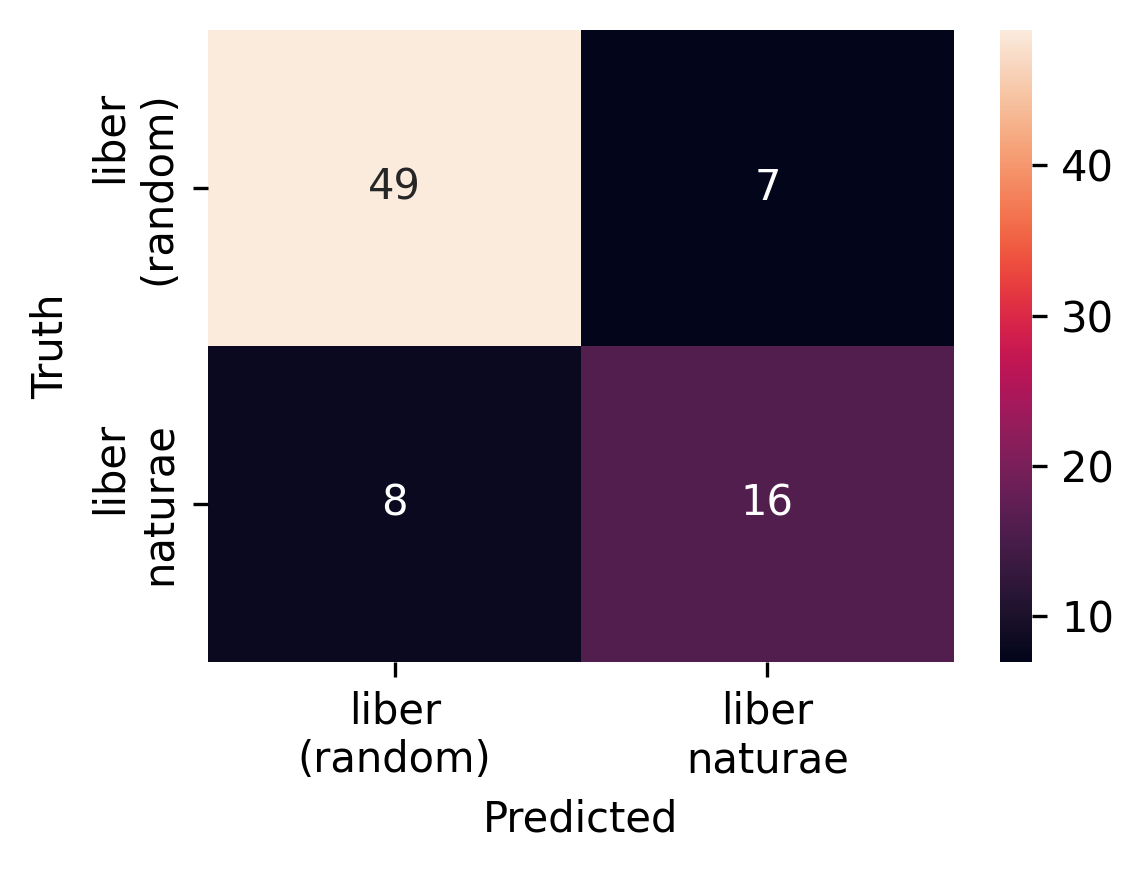

In [253]:
cm = confusion_matrix(Y_val, Y_pred)

fig, ax = plt.subplots(tight_layout=True, dpi=300, figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
ax.set_xticklabels(["liber\n(random)", "liber\nnaturae"])
ax.set_yticklabels(["liber\n(random)", "liber\nnaturae"])
